# Wear Prediction Using Regression and Classification Models

This notebook explains step-by-step how a machine learning pipeline is implemented to predict tool wear based on drilling parameters. It also interprets model evaluation metrics.

For the wear prediction, the values of FWF (Flank Wear Prediction) are considered. More information about this type of failure can be found in the dataset's literature. 

**Important**: In this notebook, only one model is created to predict the FWF for all materials. This was suggested since it can lead to a bigger model but with more overall understanding of the distribution of failure between all materials. 

**Implementation**: This approach was not implemented as the tool for the agentic system, creating a possible "next step" for the project. 

Software Lab 2025 Group 25

File made by: Adrian Almohalla (03804037)
adrian.almohalla@tum.de

Documentation made by: Adrian Almohalla (03804037) and Eduardo Silva (03805057)

## 1. Load Libraries and Dataset
We import necessary Python libraries and load the dataset used for both regression and classification.

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import HTML
import ipywidgets as widgets
from pathlib import Path

In [2]:
# Current working directory (notebook location)
BASE_DIR = Path.cwd()

# get dataset file path
file_path = BASE_DIR.parent.parent / "Dataset/XAI_Drilling_Dataset.csv"
print(file_path)

# load file
df = pd.read_csv(file_path)

print(df.head())

/home/myuser/TUM/sl-siemens/FINAL/Dataset/XAI_Drilling_Dataset.csv
   ID  Cutting speed vc [m/min]  Spindle speed n [1/min]  Feed f [mm/rev]  \
0   1                     29.92                      794            0.218   
1   2                     29.85                      792            0.241   
2   3                     22.85                      606            0.183   
3   4                     29.60                      785            0.236   
4   5                     17.43                      462            0.246   

   Feed rate vf [mm/min]  Power Pc [kW]  Cooling [%] Material Drill Bit Type  \
0                    173         194.87           75        N              W   
1                    191         214.71           75        N              W   
2                    111          95.68           50        P              N   
3                    237         206.93           75        N              W   
4                    114          74.85           50        K         

## 2. Feature Engineering
We create new columns 'Torque', 'Tf', and assign fixed hardness values by material.

$$ Torque = \frac{Power [kW]}{Spindle Speed [rpm]} = \frac{Power [W]}{Spindle Speed [rad/s]} * \frac{1000*60}{2 * \pi} \simeq 9550 * \frac{Power [W]}{Spindle Speed [rad/s]}$$

, and:

$$ Tf = \frac{Torque}{Feed \ \ [mm/rev]}$$

This new variable named "Tf" encompasses the information of the most important feature (Feed or Feed rate) and it integrates information from the torque. 

In [3]:

# create variables for Torque and for Torque / Feed
df['Torque'] = (9550 * df['Power Pc [kW]']) / df['Spindle speed n [1/min]']
df['Tf'] = df['Torque'] / df['Feed f [mm/rev]']

# store the hardness of each material provided in the dataset's paper
material_hardness = {'N': 70, 'P': 180, 'K': 160}

# create a new colum with a mapping from material's letter to material's hardness
df['Hardness'] = df['Material'].map(material_hardness)
df.head()
    

,ID,Cutting speed vc [m/min],Spindle speed n [1/min],Feed f [mm/rev],Feed rate vf [mm/min],Power Pc [kW],Cooling [%],Material,Drill Bit Type,Process Time [sec],Main Failure,BEF,CCF,FWF,WDF,Torque,Tf,Hardness
0,1,29.92,794,0.218,173,194.87,75,N,W,19.26,0,0,0,0,0,2343.839421,10751.556975,70
1,2,29.85,792,0.241,191,214.71,75,N,W,19.55,0,0,0,0,0,2588.990530,10742.699296,70
2,3,22.85,606,0.183,111,95.68,50,P,N,36.16,0,0,0,0,0,1507.828383,8239.499360,180
3,4,29.60,785,0.236,237,206.93,75,N,W,21.22,1,0,0,1,0,2517.428662,10667.070603,70
4,5,17.43,462,0.246,114,74.85,50,K,H,33.56,0,0,0,0,0,1547.224026,6289.528561,160


## 3. Visualization of Original Data (Without SMOTE or Normalization)
We visualize the real data before any processing, including calculated classes.

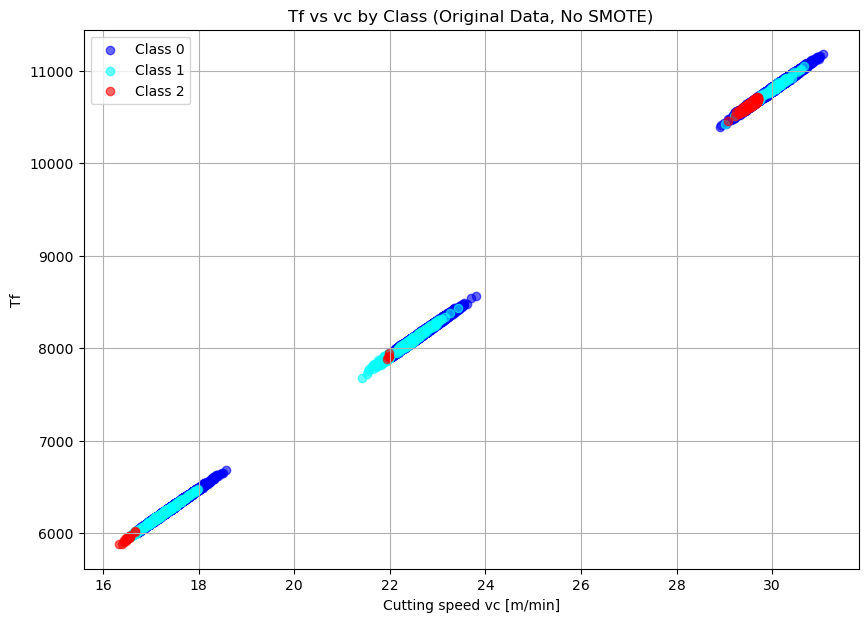

In [4]:
# choose minimums of cutting speed and Torque/feed as limits for failure
df_vc = df[df['FWF'] == 1]['Cutting speed vc [m/min]'].min()
df_tf = df[df['FWF'] == 1]['Tf'].min()

# function to classify failure FWF (leading to degradation of drilling)
# return 0 -> no degradation
# return 1 -> degradation in drilling
# return 2 -> failure of drilling flank
def classify_zone(row):
    #if values for variables are lower that the minimums for FWF = 1
    if (row['Cutting speed vc [m/min]'] <= df_vc) or (row['Tf'] <= df_tf):
        return 2
    # if FWF = 1, then clearly there is FWF Failure
    elif row['FWF'] == 1:
        return 2
    # if any other type of failure occurs but not FWF
    elif row['FWF'] == 0 and row['Main Failure'] == 1:
        return 1
    # no failures
    else:
        return 0

df['Zone_3Class'] = df.apply(classify_zone, axis=1)

#plot to visualize the different zones for values of (Tf, Cutting Speed)
plt.figure(figsize=(10, 7))
colors = {0: 'blue', 1: 'cyan', 2: 'red'}
for label in sorted(df['Zone_3Class'].unique()):
    subset = df[df['Zone_3Class'] == label]
    plt.scatter(subset['Cutting speed vc [m/min]'], subset['Tf'], color=colors[label], alpha=0.6, label=f'Class {label}')
plt.xlabel('Cutting speed vc [m/min]')
plt.ylabel('Tf')
plt.legend()
plt.grid(True)
plt.title('Tf vs vc by Class (Original Data, No SMOTE)')
plt.show()


## 4. Rule-based Labelling & Preprocessing per Material
For each material type, we perform:

- Rule-based learning of operating limits 
- Automatic assignment to 3 wear zones (0 / 1 / 2) based on vc, Tf & FWF
- Filtering out inconsistent samples based on Tf–zone contradiction
- Standardization of features (StandardScaler)

Tools used:

- pandas, numpy for rule-based zone construction
- sklearn.model_selection.train_test_split for stratified splitting
- sklearn.preprocessing.StandardScaler for feature scaling

In [5]:
# function to evaluate the limits of the different zones
# evaluates the maximum values for Tf and cutting speed (vc) for the cases where it fails
def compute_limits_per_material(dfs):
    limits = {}
    for m in dfs['Material'].unique():
        sub = dfs[dfs['Material'] == m]
        max_vc_fwf = sub.loc[sub['FWF'] == 1, 'Cutting speed vc [m/min]'].max()
        max_tf_fwf = sub.loc[sub['FWF'] == 1, 'Tf'].max()
        z = pd.Series(0, index=sub.index, dtype=int)
        z[(sub['FWF'] == 1) |
          (sub['Cutting speed vc [m/min]'] <= max_vc_fwf) |
          (sub['Tf'] <= max_tf_fwf)] = 2
        z[(sub['FWF'] != 1) & (sub['Main Failure'] == 1) & (z != 2)] = 1
        limits[m] = {
            'max_vc_fwf':  max_vc_fwf,
            'max_tf_fwf':  max_tf_fwf,
            'class2_max_tf': sub.loc[z == 2, 'Tf'].max(),
            'class1_max_tf': sub.loc[z == 1, 'Tf'].max()
        }
    return limits

# using the limits calculated above applies a filtering to make zones more clear
def apply_limits_and_label(dfs, limits):
    zone = pd.Series(-1, index=dfs.index, dtype=int)
    keep = pd.Series(True, index=dfs.index)
    for m in dfs['Material'].unique():
        sub_idx = dfs[dfs['Material'] == m].index
        sub = dfs.loc[sub_idx]
        lim = limits[m]
        z = pd.Series(0, index=sub_idx, dtype=int)
        z[(sub['FWF'] == 1) |
          (sub['Cutting speed vc [m/min]'] <= lim['max_vc_fwf']) |
          (sub['Tf'] <= lim['max_tf_fwf'])] = 2
        z[(sub['FWF'] != 1) & (sub['Main Failure'] == 1) & (z != 2)] = 1
        k = pd.Series(True, index=sub_idx)
        k[(z == 1) & (sub['Tf'] <= lim['class2_max_tf'])] = False
        k[(z == 0) & (sub['Tf'] <= lim['class1_max_tf'])] = False
        zone.loc[sub_idx] = z
        keep.loc[sub_idx] = k
    out = dfs[keep].copy()
    out['Zone_3Class'] = zone[keep].astype(int)
    return out

# obtain lower bounds for the zones 
def lower_bound_from_rules(df_subset, limits_by_material):
    lb = np.zeros(len(df_subset), dtype=int)
    for m in df_subset['Material'].unique():
        idx = (df_subset['Material'] == m)
        sub = df_subset.loc[idx]
        lim = limits_by_material[m]

        cond2 = (sub['FWF'] == 1) | \
                (sub['Cutting speed vc [m/min]'] <= lim['max_vc_fwf']) | \
                (sub['Tf'] <= lim['max_tf_fwf'])

        lb[idx.to_numpy()] = np.where(
            cond2, 2,
            np.where(sub['Main Failure'] == 1, 1, 0)
        )
    return lb

# create the train and test split
idx_train, idx_test = train_test_split(
    df.index, test_size=0.30, random_state=42, stratify=df['Material']
)
df_train = df.loc[idx_train].copy()
df_test  = df.loc[idx_test].copy()

# apply the new filtering of the data to create better results
train_limits = compute_limits_per_material(df_train)
final_train  = apply_limits_and_label(df_train, train_limits)
final_test   = apply_limits_and_label(df_test,  train_limits)

# get the values to be compared
X_train = final_train[['Cutting speed vc [m/min]', 'Tf', 'Hardness']].values
y_train = final_train['Zone_3Class'].values
X_test  = final_test[['Cutting speed vc [m/min]', 'Tf', 'Hardness']].values
y_test  = final_test['Zone_3Class'].values

# apply a scaler to make the values normalized
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

## 5. XGBoost Training (3-class Wear Prediction)
Inside classifier:
- Handle class imbalance via sample weights
- Build XGBoost training matrix
- Train a constrained gradient-boosted tree model
- Select the optimal number of trees via cross-validation
- Train final model

In [6]:

# Define sample weights for training
w_train = np.ones_like(y_train, dtype=float)
w_train[y_train==1] = 2.0
w_train[y_train==2] = 1.3

dtrain_full = xgb.DMatrix(X_train_s, label=y_train, weight=w_train)

# XGBoost parameters
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'eta': 0.05,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.2,
    'lambda': 1.2,
    'monotone_constraints': '(1,1,0)',
    'seed': 42,
    'nthread': -1
}

# Cross-validation to avoid overfitting
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain_full,
    num_boost_round=800,
    nfold=3,
    stratified=True,
    early_stopping_rounds=50,
    metrics='mlogloss',
    verbose_eval=False
)

best_iters = len(cv_results)

# Train final model
booster = xgb.train(params=params, dtrain=dtrain_full, num_boost_round=best_iters)

## 6. Prediction & Physically-Constrained Post-processing
Train set predictions
- Predict class probabilities using booster.predict(·)
- Select most likely class per sample (argmax)
- Compute rule-based lower bound using lower_bound_from_rules(·)
  - minimum admissible wear zone according to physical constraints
- Final predicted zone = max(model_prediction, rule_lower_bound)
  - enforces consistency with operating-limit rules

Test set predictions
- XGBoost probability prediction
- Argmax
  - raw class prediction
- Rule-based lower bound from material-dependent limits
- Final class = max(raw, rule_lower_bound)

In [7]:
# Train predictions
dtrain = xgb.DMatrix(X_train_s)
probs_train = booster.predict(dtrain, iteration_range=(0, best_iters))
y_argmax_train = np.argmax(probs_train, axis=1)

lb_train = lower_bound_from_rules(final_train, train_limits)
train_pred = np.maximum(y_argmax_train, lb_train)

# Test predictions
dtest = xgb.DMatrix(X_test_s)
probs_test = booster.predict(dtest, iteration_range=(0, best_iters))
y_argmax   = np.argmax(probs_test, axis=1)

lb_test    = lower_bound_from_rules(final_test, train_limits)
y_pred     = np.maximum(y_argmax, lb_test)

## 7. Confusion matrix plot


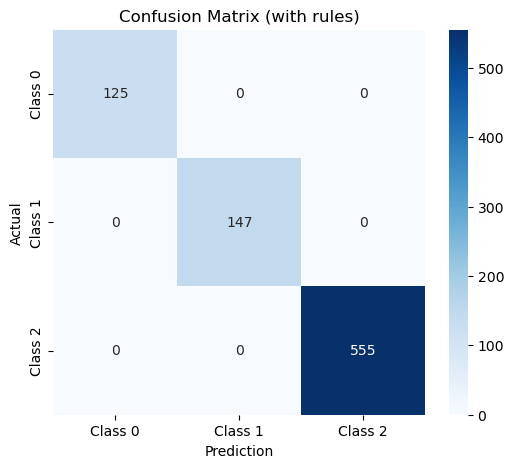

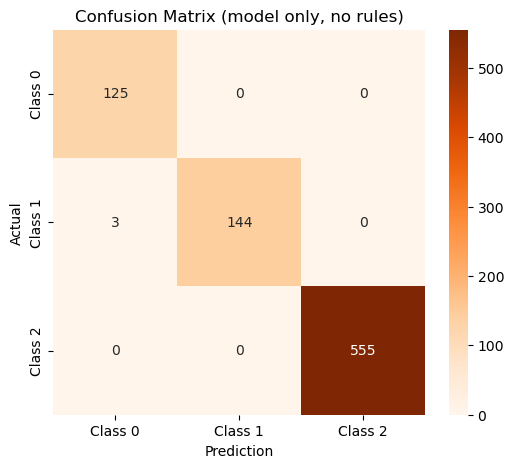

Downward violations in TEST (must be 0): 0
Changed by rules in TEST: 3


In [8]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix (with rules)")
plt.show()

# No rules - for comparison
y_pred_raw = np.argmax(probs_test, axis=1)

cm_raw = confusion_matrix(y_test, y_pred_raw)

plt.figure(figsize=(6,5))
sns.heatmap(cm_raw, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix (model only, no rules)")
plt.show()

print("Downward violations in TEST (must be 0):", int((y_pred < y_argmax).sum()))
print("Changed by rules in TEST:", int((y_pred != y_argmax).sum()))



## 8. Performance Metrics Comparison per Class (Precision, Recall and F1-Score)

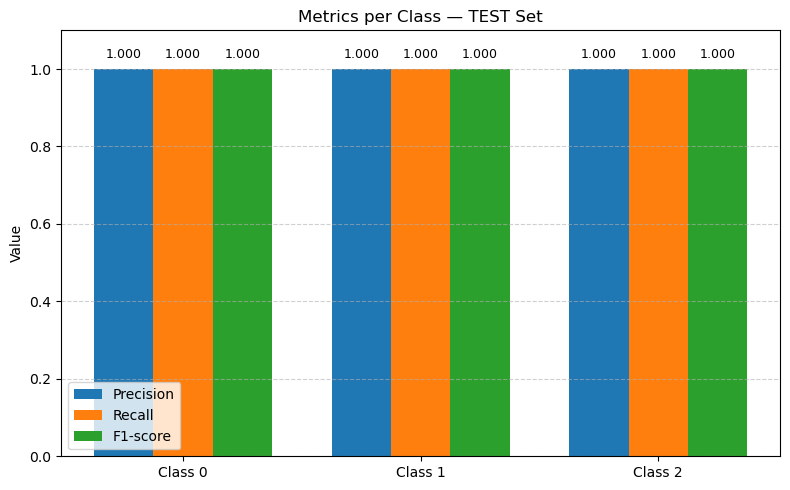

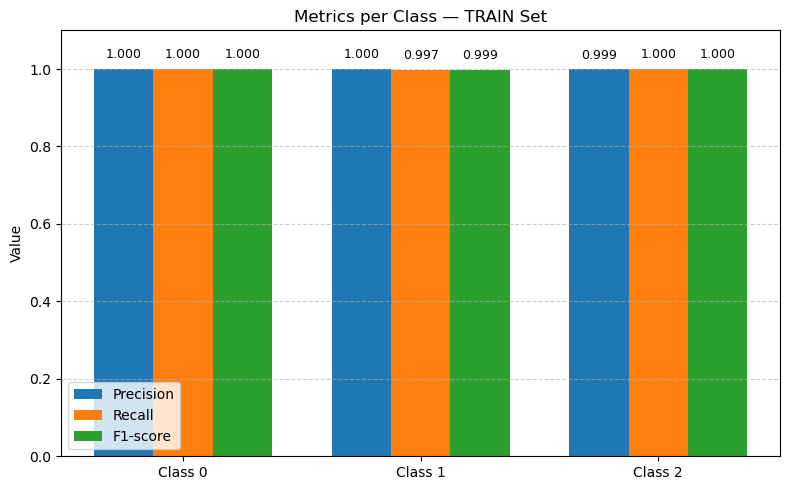

In [9]:
prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred)

labels = ["Class 0", "Class 1", "Class 2"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width, prec, width, label='Precision')
bars2 = ax.bar(x, rec, width, label='Recall')
bars3 = ax.bar(x + width, f1, width, label='F1-score')

ax.set_ylabel("Value")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.set_title("Metrics per Class — TEST Set")
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f"{height:.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#Train set metrics plot
prec_tr, rec_tr, f1_tr, sup_tr = precision_recall_fscore_support(y_train, train_pred)

labels = ["Class 0", "Class 1", "Class 2"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width, prec_tr, width, label='Precision')
bars2 = ax.bar(x,       rec_tr, width, label='Recall')
bars3 = ax.bar(x + width, f1_tr, width, label='F1-score')

ax.set_ylabel("Value")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.set_title("Metrics per Class — TRAIN Set")
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f"{height:.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 9. Comparison of Macro F1-Score Between Training and Test Sets

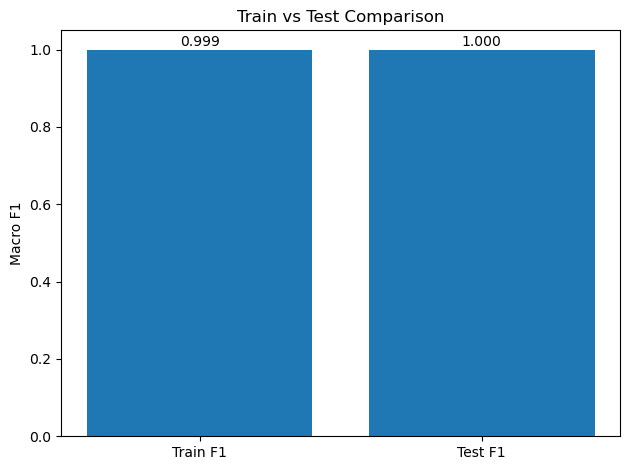

In [10]:
train_F1 = f1_score(y_train, train_pred, average='macro')
test_F1  = f1_score(y_test,  y_pred,      average='macro')

fig, ax = plt.subplots()
ax.bar([0, 1], [train_F1, test_F1])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Train F1", "Test F1"])
ax.set_ylim(0, 1.05)
ax.set_ylabel("Macro F1")
ax.set_title("Train vs Test Comparison")

for i, v in enumerate([train_F1, test_F1]):
    ax.text(i, v + 0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

## 10. Correct vs Incorrect Predictions in the Physical Domain (Test Set)

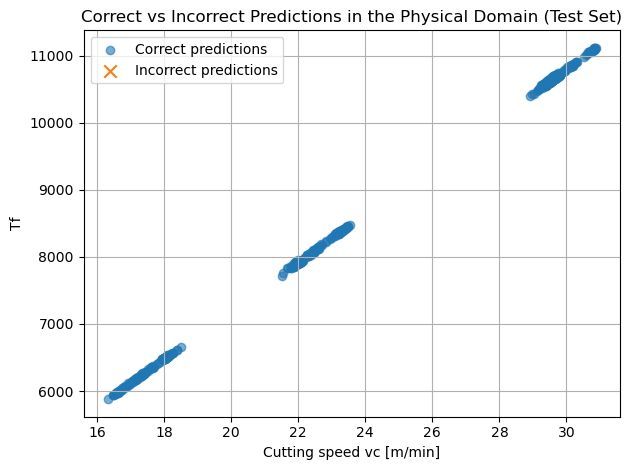

In [11]:
vc = final_test['Cutting speed vc [m/min]'].values
tf = final_test['Tf'].values

y_test_arr = np.array(y_test)
y_pred_arr = np.array(y_pred)

correct = y_test_arr == y_pred_arr

fig, ax = plt.subplots()

ax.scatter(vc[correct], tf[correct], alpha=0.6, label="Correct predictions")
ax.scatter(vc[~correct], tf[~correct], marker='x', s=80, label="Incorrect predictions")

ax.set_xlabel("Cutting speed vc [m/min]")
ax.set_ylabel("Tf")
ax.set_title("Correct vs Incorrect Predictions in the Physical Domain (Test Set)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

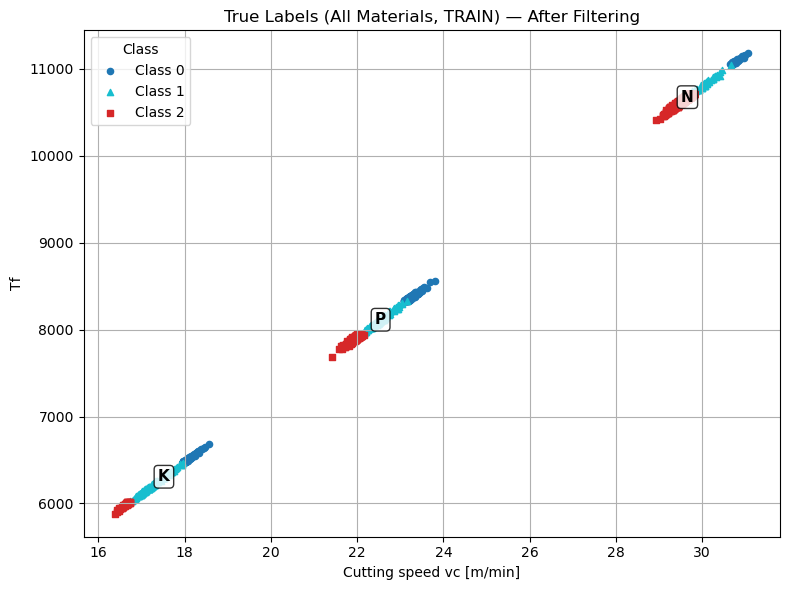

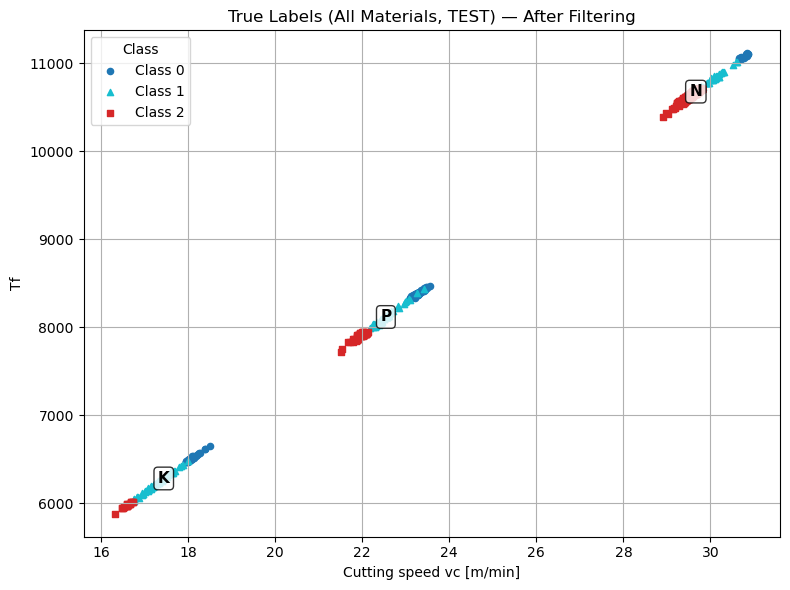

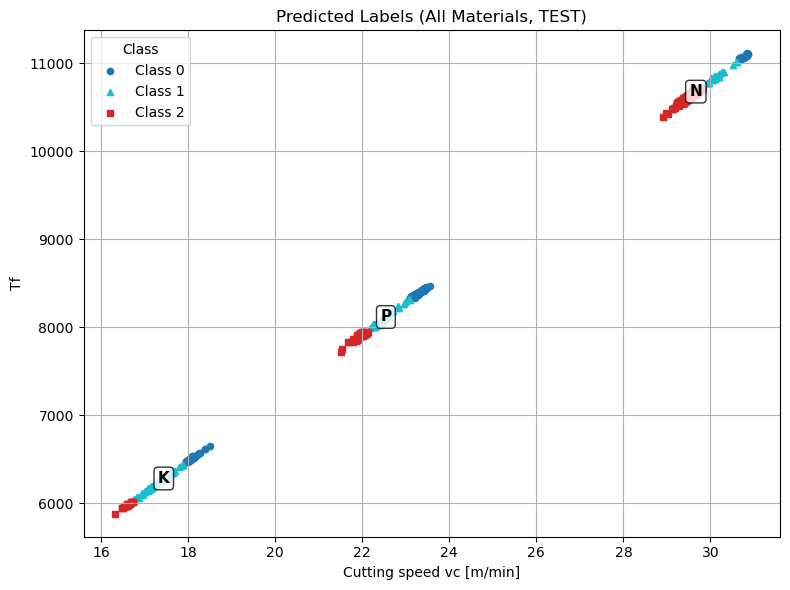

In [13]:
markers = {0: 'o', 1: '^', 2: 's'}
colors  = {0: 'tab:blue', 1: 'tab:cyan', 2: 'tab:red'}

def annotate_material_centroids(ax, data):
    for m, sub in data.groupby('Material'):
        ax.text(
            sub['Cutting speed vc [m/min]'].mean(),
            sub['Tf'].mean(),
            m,
            fontsize=11,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='black', alpha=0.8)
        )

# plot all materials showing the different regions
def plot_labels(data, label_col, title):
    fig, ax = plt.subplots(figsize=(8, 6))

    for label in sorted(data[label_col].unique()):
        mask = (data[label_col] == label)
        ax.scatter(
            data.loc[mask, 'Cutting speed vc [m/min]'],
            data.loc[mask, 'Tf'],
            marker=markers.get(label, 'o'),
            c=colors.get(label, 'grey'),
            s=20,
            label=f'Class {label}'
        )

    ax.set_xlabel('Cutting speed vc [m/min]')
    ax.set_ylabel('Tf')
    ax.set_title(title)
    ax.legend(title='Class', loc='upper left')
    annotate_material_centroids(ax, data)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


plot_labels(final_train, 'Zone_3Class', 'True Labels (All Materials, TRAIN) — After Filtering')
plot_labels(final_test,  'Zone_3Class', 'True Labels (All Materials, TEST) — After Filtering')

test_with_pred = final_test.copy()
test_with_pred['PredClass'] = y_argmax
plot_labels(test_with_pred, 'PredClass', 'Predicted Labels (All Materials, TEST)')


## 11. Example: Predicting Wear for a New Input
You can now use the trained models to predict wear for new inputs.

In [14]:
if "regressors" not in globals():
    regressors = {}
    for m in df["Material"].unique():
        sub = df[df["Material"] == m].copy()
        reg = LinearRegression().fit(
            sub[["Hardness", "Feed f [mm/rev]"]],
            sub["Torque"]
        )
        regressors[m] = reg

if "_wear_root" in globals():
    try:
        _wear_root.close()
    except Exception:
        pass

required = ["material_hardness", "regressors", "scaler", "booster", "best_iters"]
missing = [k for k in required if k not in globals()]

def render_wear_card(material_input: str, feed: float, vc: float) -> str:
    hardness = material_hardness[material_input]

    X_reg = pd.DataFrame([[hardness, feed]], columns=["Hardness", "Feed f [mm/rev]"])
    torque_pred = float(regressors[material_input].predict(X_reg)[0])
    tf = torque_pred / feed

    X = np.array([[vc, tf, hardness]], dtype=float)
    Xs = scaler.transform(X)
    dX = xgb.DMatrix(Xs)
    p_safe, p_warn, p_fail = booster.predict(dX, iteration_range=(0, best_iters))[0]

    wear_estimated = p_safe * 5 + p_warn * 50 + p_fail * 100

    if (p_fail >= 0.10) or (wear_estimated >= 70) or (p_fail == max(p_safe, p_warn, p_fail)):
        status = "Recommendation: CHANGE TOOL (conservative trigger)."
    elif (p_warn >= 0.40) or (wear_estimated >= 35):
        status = "Recommendation: MONITOR TOOL (warning risk)."
    else:
        status = "Recommendation: CONTINUE MACHINING (low wear)."

    return f"""
    <div style="font-family: Inter, Arial; max-width: 980px; border:1px solid #e5e7eb;
                border-radius:22px; padding:26px; box-shadow:0 10px 28px rgba(0,0,0,.10);">
      <h1 style="margin:0 0 10px 0; font-size:44px; font-weight:800;">Tool Wear Estimation</h1>
      <div style="margin:6px 0 18px 0; font-size:22px; font-weight:700;">{status}</div>

      <div style="display:grid; grid-template-columns: 1fr 1fr; gap:14px; font-size:20px;">
        <div><b>Material:</b> {material_input} (Hardness {hardness})</div>
        <div><b>Feed:</b> {feed:.3f} mm/rev</div>
        <div><b>Cutting speed:</b> {vc:.2f} m/min</div>
        <div><b>Predicted torque:</b> {torque_pred:,.2f} Nm</div>
        <div><b>Tf:</b> {tf:,.2f}</div>
        <div><b>Estimated wear:</b> {wear_estimated:.1f}%</div>
      </div>

      <h2 style="margin:26px 0 10px 0; font-size:34px;">Probabilities</h2>

      <div style="font-size:22px; margin-bottom:6px; display:flex; justify-content:space-between;">
        <span>Safe (Zone 0)</span><b>{p_safe*100:.1f}%</b>
      </div>
      <div style="height:16px; background:#e5e7eb; border-radius:999px; overflow:hidden; margin-bottom:14px;">
        <div style="width:{p_safe*100:.1f}%; height:16px; background:#3b82f6;"></div>
      </div>

      <div style="font-size:22px; margin-bottom:6px; display:flex; justify-content:space-between;">
        <span>Warning (Zone 1)</span><b>{p_warn*100:.1f}%</b>
      </div>
      <div style="height:16px; background:#e5e7eb; border-radius:999px; overflow:hidden; margin-bottom:14px;">
        <div style="width:{p_warn*100:.1f}%; height:16px; background:#06b6d4;"></div>
      </div>

      <div style="font-size:22px; margin-bottom:6px; display:flex; justify-content:space-between;">
        <span>Fail (Zone 2)</span><b>{p_fail*100:.1f}%</b>
      </div>
      <div style="height:16px; background:#e5e7eb; border-radius:999px; overflow:hidden;">
        <div style="width:{p_fail*100:.1f}%; height:16px; background:#ef4444;"></div>
      </div>
    </div>
    """

material_w = widgets.Dropdown(options=["N","P","K"], value="P", description="Material:")
feed_w     = widgets.BoundedFloatText(value=0.20, min=0.01, max=2.00, step=0.01, description="Feed:")
vc_w       = widgets.BoundedFloatText(value=100.0, min=0.1, max=500.0, step=1.0, description="vc:")
btn        = widgets.Button(description="Estimate wear", button_style="primary")
out        = widgets.Output()

try:
    btn._click_handlers.callbacks.clear()
except Exception:
    pass

def on_click(_):
    out.clear_output(wait=True)
    with out:
        missing_now = [k for k in required if k not in globals()]
        if missing_now:
            out.append_display_data(HTML(f"""
            <div style="font-family: Inter, Arial; max-width:980px; border:1px solid #fecaca;
                        background:#fff1f2; border-radius:16px; padding:16px;">
              <b style="color:#991b1b; font-size:20px;">Missing objects in memory:</b>
              <div style="margin-top:8px; font-size:18px;">{", ".join(missing_now)}</div>
              <div style="margin-top:10px; font-size:16px; color:#374151;">
                Run your training/loading cells first (especially the one creating <code>regressors</code>).
              </div>
            </div>
            """))
            return

        html = render_wear_card(material_w.value, float(feed_w.value), float(vc_w.value))
        out.append_display_data(HTML(html))

btn.on_click(on_click)

_wear_root = widgets.VBox([widgets.HBox([material_w, feed_w, vc_w, btn]), out])
display(_wear_root)
